In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter
import seaborn as sns
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.util import ngrams



nltk.download('punkt')
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from nltk.tokenize import word_tokenize
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# CNN
from sklearn import model_selection
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Embedding
from tensorflow.keras import layers


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/matthieu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/matthieu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
2022-05-17 02:46:30.895745: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-17 02:46:30.895760: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
pip install spacy

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


-----------------
# Data Visualasation

In [2]:
wikinews_df = pd.read_csv("/home/matthieu/Documents/S8/TAL/df_wikinews_pr_tok_sample.csv", sep=",", dtype={'categ': 'category'})
wikinews_df

,title,text,categ
0,Tournoi des Quatre Nations 2017 : les résultat...,Rugby à XV Informations générales Internationa...,sports
1,"Pas de pardon pour Stanley Williams , le fonda...","13 décembre 2005 . – Stanley "" Tookie "" Willia...",justice
2,France : les époux Mégret sont condamnés pour ...,18 octobre 2006 . – Par un jugement rendu ce j...,polit
3,Championnat de France de basket - ball de Pro ...,17 octobre 2011 . – Cette deuxième journée est...,sports
4,Coupe d' Europe de rugby 2017 - 2018 : les rés...,Rugby à XV Informations générales Internationa...,sports
...,...,...,...
9995,"Chili : un séisme de magnitude 5,9 à Pichilemu...",Carte après la réplique Source : Institut d'...,enviro_cat
9996,Procès de trois polluposteurs aux États - Unis,Quartier général du département de la Justice ...,justice
9997,Sommet sino-africain : investissement de la Ch...,5 novembre 2006 . – Le 3ème sommet Chine - Afr...,economie
9998,Québec : des conduites en amiante - ciment uti...,Un tuyau d' amiante - ciment typique . Benoit ...,enviro_cat


In [3]:
wikinews_df = wikinews_df.drop_duplicates().dropna(how = 'any')
wikinews_df

# le dataset de contient pas de duplication ou de champs non assignés

,title,text,categ
0,Tournoi des Quatre Nations 2017 : les résultat...,Rugby à XV Informations générales Internationa...,sports
1,"Pas de pardon pour Stanley Williams , le fonda...","13 décembre 2005 . – Stanley "" Tookie "" Willia...",justice
2,France : les époux Mégret sont condamnés pour ...,18 octobre 2006 . – Par un jugement rendu ce j...,polit
3,Championnat de France de basket - ball de Pro ...,17 octobre 2011 . – Cette deuxième journée est...,sports
4,Coupe d' Europe de rugby 2017 - 2018 : les rés...,Rugby à XV Informations générales Internationa...,sports
...,...,...,...
9995,"Chili : un séisme de magnitude 5,9 à Pichilemu...",Carte après la réplique Source : Institut d'...,enviro_cat
9996,Procès de trois polluposteurs aux États - Unis,Quartier général du département de la Justice ...,justice
9997,Sommet sino-africain : investissement de la Ch...,5 novembre 2006 . – Le 3ème sommet Chine - Afr...,economie
9998,Québec : des conduites en amiante - ciment uti...,Un tuyau d' amiante - ciment typique . Benoit ...,enviro_cat


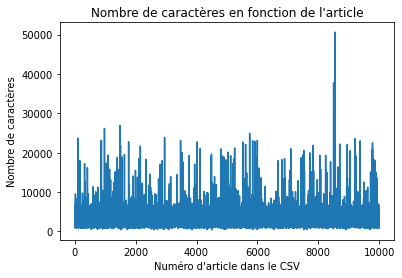

In [5]:
char_nb = wikinews_df['text'].str.len()
id = wikinews_df.index
plt.plot(id, char_nb)
plt.title("Nombre de caractères en fonction de l'article")
plt.xlabel("Numéro d'article dans le CSV")
plt.ylabel("Nombre de caractères")
plt.show()

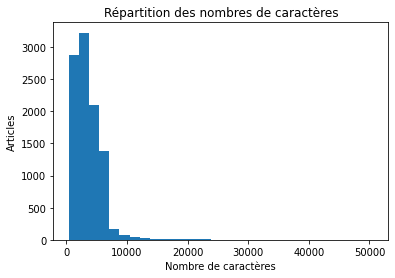

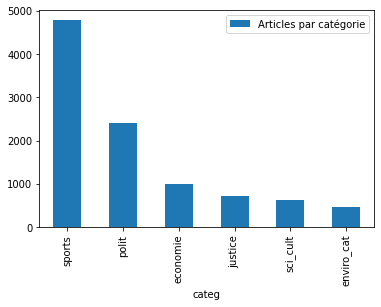

In [6]:
char = wikinews_df['text'].str.len()
categ = wikinews_df["categ"]

plt.hist(char, bins = 30)
plt.title("Répartition des nombres de caractères")
plt.xlabel("Nombre de caractères")
plt.ylabel("Articles")
plt.show()


wikinews_df_plot = wikinews_df.groupby('categ').size().reset_index(name='Articles par catégorie').sort_values('Articles par catégorie', ascending=False).plot.bar(x='categ')
#wikinews_df_plot.size().plot.bar()

# Les articles Wikinews vont jusqu'à plus de 25 000 caractères, mais la majorité en a entre 0 et 5000

In [96]:
stop_fr = set(stopwords.words('french'))

from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop

In [8]:
#détection des stopwords qui ne seront pas pertinent à l'analyse
corpus = []
new = wikinews_df['text'].str.split() # Les tokens sont séparés par un espace, split() permet de récupérer ces derniers
new = new.values.tolist()
corpus=[word for i in new for word in i]

dic=defaultdict(int)
for word in corpus:
    if word in stop_fr:
        dic[word]+=1

<BarContainer object of 15 artists>

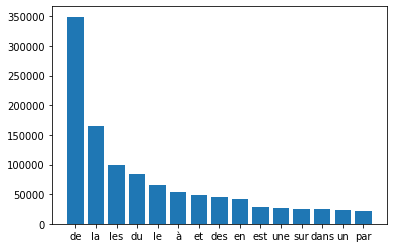

In [9]:
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:15] 
x,y=zip(*top)
plt.bar(x,y)

/home/matthieu/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


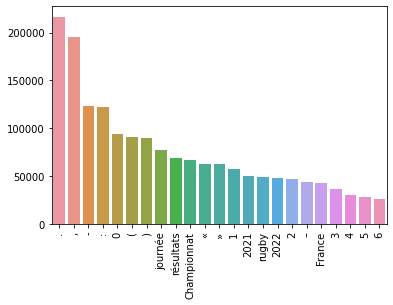

In [76]:
#détection de mots fréquents n'étant pas des stopwords

counter = Counter(corpus)
frequent = counter.most_common()

x = []
y = []
for mot, frequence in frequent[:40]:
    if (mot not in fr_stop):
        x.append(mot)
        y.append(frequence)

bar_plot = sns.barplot(x, y)
plt.xticks(rotation=90)
plt.show()

/home/matthieu/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


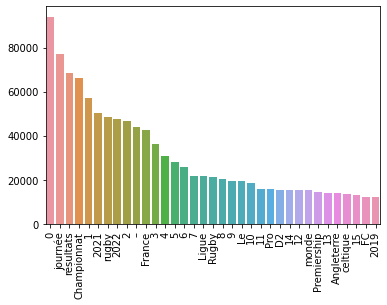

['0', 'journée', 'résultats', 'Championnat', '1', '2021', 'rugby', '2022', '2', '–', 'France', '3', '4', '5', '6', '7', 'Ligue', 'Rugby', '8', '9', 'Le', '10', '11', 'Pro', 'D2', '14', '12', 'monde', 'Premiership', '13', 'Angleterre', 'celtique', '15', 'FC', '2019']


In [75]:
# On enlève la ponctuation

counter = Counter(corpus)
frequent = counter.most_common()

x = []
y = []
for mot, frequence in frequent[:70]:
    if (mot not in fr_stop and mot not in list(string.punctuation) + ['«', '»', 'fr', 'page', 'Wikinews', 'article']):
        x.append(mot)
        y.append(frequence)

bar_plot = sns.barplot(x, y)
plt.xticks(rotation=90)
plt.show()

print(x)

# Chiffres restent bien discriminants pour les articles de sports, on les enlève pas

<AxesSubplot:>

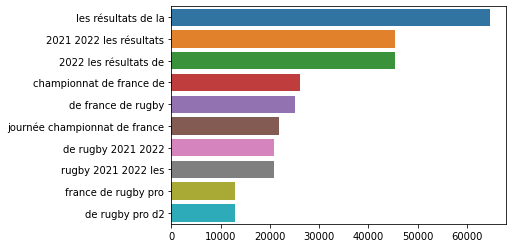

In [12]:

# Param : N to control size of n-grams

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

top_n_bigrams=get_top_ngram(wikinews_df['text'], n=4)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

----------------
# Tf Idf

-------------------
## Data Preparation and Tf Idf pipeline

In [78]:
# Extraction de X et Y et découpage en train et test
X_categ = wikinews_df[['title', 'text']]
Y_categ = wikinews_df['categ']

In [79]:
X_train, X_test, Y_train, Y_test = train_test_split(X_categ, Y_categ, test_size=0.2, random_state=7, shuffle=True)

In [80]:
# Classe pour sélectionner des colonnes à partir de leur nom

class SingleColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, data_dict):
        return data_dict[self.key]

In [113]:
import stanza
nlp_st = stanza.Pipeline('fr', processors='tokenize,mwt,pos,lemma', tokenize_pretokenized=True)

2022-05-17 00:45:57 INFO: Loading these models for language: fr (French):
| Processor | Package |
-----------------------
| tokenize  | gsd     |
| mwt       | gsd     |
| pos       | gsd     |
| lemma     | gsd     |

2022-05-17 00:45:57 INFO: Use device: cpu
2022-05-17 00:45:57 INFO: Loading: tokenize
2022-05-17 00:45:57 INFO: Loading: mwt
2022-05-17 00:45:57 INFO: Loading: pos
2022-05-17 00:45:57 INFO: Loading: lemma
2022-05-17 00:45:57 INFO: Done loading processors!


In [151]:
# The documents are already tokenized

def lemmatize(text):
        
        in_doc = stanza.Document([], text=text)
        doc = nlp_st(text)
        lemnas = [word.lemma for sent in doc.sentences for word in sent.words]
        return lemnas

from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

def stem_text(text):
        
        tokens = [word for word in nltk.word_tokenize(text) if len(word) > 1]
        stems = [stemmer.stem(item) for item in tokens if item not in fr_stop]
        return stems

In [153]:
#pipeline pour les textes

# Liste des mots outils de Spacy + signes de ponctuation + séléction de stop_words
stopwords = fr_stop | set((string.punctuation)) | {'«', '»', 'fr', 'page', 'wikinews', 'article', '``', 'articl', 'qu', 'wikinew'}
    
# Objet TfidfVectorizer
desc_vectorizer = TfidfVectorizer(tokenizer=stem_text, 
                                lowercase=True,
                                stop_words=stopwords, 
                                min_df=0.00008)

# Pipeline spécifique
texte_pipeline = make_pipeline(
    SingleColumnSelector(key="text"),
    desc_vectorizer
)
texte_pipeline

Pipeline(steps=[('singlecolumnselector', SingleColumnSelector(key='text')),
                ('tfidfvectorizer',
                 TfidfVectorizer(min_df=8e-05,
                                 stop_words={'!', '"', '#', '$', '%', '&', "'",
                                             '(', ')', '*', '+', ',', '-', '.',
                                             '/', ':', ';', '<', '=', '>', '?',
                                             '@', '[', '\\', ']', '^', '_', '`',
                                             'a', 'abord', ...},
                                 tokenizer=<function stem_text at 0x7fa0ed7d69d0>))])

In [154]:
# Chaîne de pré-traitement globale
preprocess_pipeline2 = make_pipeline(
        texte_pipeline
)

In [155]:
# Chaîne de classification

classifier_pipeline2 = make_pipeline(
    preprocess_pipeline2,
    LogisticRegression()
)


-------------------
## Training

In [156]:
# Apprentissage avec les données d'entraînement
classifier_pipeline2.fit(X_train, Y_train)

/home/matthieu/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:394: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``', 'articl', 'qu', 'wikinew'] not in stop_words.
  warnings.warn(
/home/matthieu/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('pipeline',
                                  Pipeline(steps=[('singlecolumnselector',
                                                   SingleColumnSelector(key='text')),
                                                  ('tfidfvectorizer',
                                                   TfidfVectorizer(min_df=8e-05,
                                                                   stop_words={'!',
                                                                               '"',
                                                                               '#',
                                                                               '$',
                                                                               '%',
                                                                               '&',
                                                                               "'",
                                                                               '(',
                                                                               ')',
                                                                               '*',
                                                                               '+',
                                                                               ',',
                                                                               '-',
                                                                               '.',
                                                                               '/',
                                                                               ':',
                                                                               ';',
                                                                               '<',
                                                                               '=',
                                                                               '>',
                                                                               '?',
                                                                               '@',
                                                                               '[',
                                                                               '\\',
                                                                               ']',
                                                                               '^',
                                                                               '_',
                                                                               '`',
                                                                               'a',
                                                                               'abord', ...},
                                                                   tokenizer=<function stem_text at 0x7fa0ed7d69d0>))]))])),
                ('logisticregression', LogisticRegression())])

-------------------------
## Test and metrics

In [157]:
# Prédiction sur les données de test

all_predictions = classifier_pipeline2.predict(X_test)
print('accuracy', accuracy_score(Y_test, all_predictions))

accuracy 0.865


In [47]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

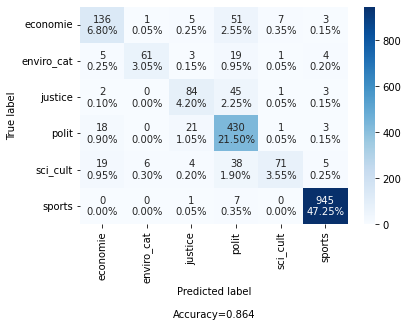

In [148]:
# Matrice de confusion

labels = np.unique(Y_test)
cm =  confusion_matrix(Y_test, all_predictions, labels=labels)
make_confusion_matrix(cm, categories=labels, sum_stats=True)

--------------
# CNN

-------------
## Preparation des données

In [4]:
# Liste des classes
class_names = sorted(wikinews_df.categ.unique().categories.to_list())
print("Classes :", class_names)
print("Nombre d'articles :", len(wikinews_df))

Classes : ['economie', 'enviro_cat', 'justice', 'polit', 'sci_cult', 'sports']
Nombre d'articles : 10000


In [5]:
# On associe à chaque classe un identifiant unique
class_index = {class_names[i]:i for i in range(len(class_names))}
class_index

{'economie': 0,
 'enviro_cat': 1,
 'justice': 2,
 'polit': 3,
 'sci_cult': 4,
 'sports': 5}

In [6]:
# Extraction de X et Y et découpage en train et test
X_categ = wikinews_df[['title', 'text']]
Y_categ = wikinews_df.categ.map(class_index)


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_categ, Y_categ, test_size=0.2, random_state=7, shuffle=True)

In [163]:
X_categ

,title,text
0,"[tournoi, quatr, nation, 2017, résultat, journé]","[rugbi, xv, inform, générale, intern, champion..."
1,"[pa, pardon, stanley, william, fondateur, gang...","[13, décembr, 2005, stanley, ``, tooki, ``, wi..."
2,"[franc, époux, mégret, condamné, détournement,...","[18, octobr, 2006, par, jugement, rendu, jour,..."
3,"[championnat, franc, basket, ball, pro, 2011, ...","[17, octobr, 2011, cett, journé, marqué, baske..."
4,"[coup, europ, rugbi, 2017, 2018, résultat, qua...","[rugbi, xv, inform, générale, intern, champion..."
...,...,...
9995,"[chili, séism, magnitud, 5,9, pichilemu, laiss...","[cart, répliqu, sourc, institut, étude, géolog..."
9996,"[procè, polluposteur, état, uni]","[quartier, général, département, justic, washi..."
9997,"[sommet, sino-africain, investiss, chine, afriqu]","[novembr, 2006, le, 3ème, sommet, chine, afriq..."
9998,"[québec, conduit, amiant, ciment, utilisé, rés...","[un, tuyau, amiant, ciment, typiqu, benoit, ch..."


In [29]:
#!wget -P data https://git.unistra.fr/dbernhard/ftaa_data/-/raw/main/model_6.txt
#!wget -P data https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.vec.gz # Plongement Fr fasttext

'''
import gzip
import shutil
with gzip.open('data/cc.fr.300.vec.gz', 'rb') as f_in:
    with open('data/cc.fr.300.vec', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
'''

"\nimport gzip\nimport shutil\nwith gzip.open('data/cc.fr.300.vec.gz', 'rb') as f_in:\n    with open('data/cc.fr.300.vec', 'wb') as f_out:\n        shutil.copyfileobj(f_in, f_out)\n"

In [8]:
embeddings_index = {}
with open('data/cc.fr.300.vec', 'r', encoding='utf8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f'{len(embeddings_index)} vecteurs de mots ont été lus')

319439 vecteurs de mots ont été lus


In [9]:
vectorizer = TextVectorization(max_tokens=100000, standardize='lower', output_sequence_length=200)

text_ds = tf.data.Dataset.from_tensor_slices(X_categ)

vectorizer.adapt(text_ds)

2022-05-17 02:47:40.210619: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-17 02:47:40.210699: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (matthieu-XPS-15-9570): /proc/driver/nvidia/version does not exist
2022-05-17 02:47:40.212243: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
voc = vectorizer.get_vocabulary()
print(len(voc))

100000


In [12]:
word_index = dict(zip(voc, range(len(voc))))

In [13]:
num_tokens = len(voc)
embedding_dim = 300
hits = 0
misses = 0

# Préparation de la matrice
# Les mots qui ne se trouvent pas dans les plongements pré-entraînés seront 
# représentés par des vecteurs dont toutes les composantes sont égales à 0,
# y compris la représentation utilisée pour compléter les documents courts et
# celle utilisée pour les mots inconnus [UNK]
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print(f'{hits} mots ont été trouvés dans les plongements pré-entraînés')
print(f'{misses} sont absents')

43689 mots ont été trouvés dans les plongements pré-entraînés
56311 sont absents


## 4. Construction et entraînement du modèle


Nous allons faire une validation croisée à 5 plis.

In [15]:
# Listes utilisées pour sauvegarder les résultats obtenus à chaque pli
acc_per_fold = []
loss_per_fold = []
histories = []
folds = 5
stratkfold = model_selection.StratifiedKFold(n_splits=folds, shuffle=True, 
                                             random_state=12)
fold_no = 1
for train, test in stratkfold.split(X_train, y_train):
  # Création du modèle  
  embedding_layer = Embedding(num_tokens, embedding_dim, trainable=True,
      embeddings_initializer=keras.initializers.Constant(embedding_matrix),
  )
  
  # title channel
  input_title = keras.Input(shape=(None,), dtype="int64")
  embedded_sequences = embedding_layer(input_title)
  y = layers.Conv1D(64, 5, activation="relu")(embedded_sequences)
  y = layers.MaxPooling1D(5)(y)
  y = layers.Conv1D(64, 5, activation="relu")(y)
  y = layers.GlobalMaxPooling1D()(y)
  y = layers.Flatten()(y)
  
  # text channel
  input_text = keras.Input(shape=(None,), dtype="int64")
  embedded_sequences = embedding_layer(input_text)
  x = layers.Conv1D(64, 5, activation="relu")(embedded_sequences)
  x = layers.MaxPooling1D(5)(x)
  x = layers.Conv1D(64, 5, activation="relu")(x)
  x = layers.GlobalMaxPooling1D()(x)
  x = layers.Flatten()(x)
  
  merged = layers.concatenate([x, y])
  
  merged = layers.Dense(64, activation="relu")(merged)
  merged = layers.Dropout(0.5)(merged)
  preds = layers.Dense(len(class_names), activation="softmax")(merged)
  model = keras.Model(inputs=[input_title, input_text], outputs=preds)
  model.summary()
  

  print('------------------------------------------------------------------------')
  print(f'Entraînement pour le pli {fold_no} ...')
  fold_x_train_text = vectorizer(X_train.iloc[train]['text'].to_numpy()).numpy()
  fold_x_val_text = vectorizer(X_train.iloc[test]['text'].to_numpy()).numpy()
  fold_x_train_title = vectorizer(X_train.iloc[train]['title'].to_numpy()).numpy()
  fold_x_val_title = vectorizer(X_train.iloc[test]['title'].to_numpy()).numpy()
  
  fold_x_train = [fold_x_train_title, fold_x_train_text]
  fold_x_val = [fold_x_val_title, fold_x_val_text]
  fold_y_train = y_train.iloc[train].to_numpy()
  fold_y_val = y_train.iloc[test].to_numpy()

  # Compilation du modèle : permet de préciser la fonction de perte et l'optimiseur
  # loss=sparse_categorical_crossentropy : entropie croisée, dans le cas où les 
  #  classes cibles sont indiquées sous forme d'entiers. Il s'agira de minimiser
  #  la perte pendant l'apprentissage
  # optimizer=rmsprop : l'optimiseur détermine la manière doit les poids seront
  #  mis à jour pendant l'apprentissage
  model.compile(
    loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["acc"]
  )
  # Entraînement
  history = model.fit(fold_x_train, fold_y_train, batch_size=128, epochs=10, 
            validation_data=(fold_x_val, fold_y_val))
  histories.append(history)
  # Evaluation sur les données de validation
  scores = model.evaluate(fold_x_val, fold_y_val, verbose=0)
  print(f'Scores pour le pli {fold_no}: {model.metrics_names[0]} = {scores[0]:.2f};',
        f'{model.metrics_names[1]} = {scores[1]*100:.2f}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])
  fold_no = fold_no + 1

# Affichage des scores moyens par pli
print('---------------------------------------------------------------------')
print('Scores par pli')
for i in range(0, len(acc_per_fold)):
  print('---------------------------------------------------------------------')
  print(f'> Pli {i+1} - Loss: {loss_per_fold[i]:.2f}',
        f'- Accuracy: {acc_per_fold[i]:.2f}%')
print('---------------------------------------------------------------------')
print('Scores moyens pour tous les plis :')
print(f'> Accuracy: {np.mean(acc_per_fold):.2f}',
      f'(+- {np.std(acc_per_fold):.2f})')
print(f'> Loss: {np.mean(loss_per_fold):.2f}')
print('---------------------------------------------------------------------')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, None, 300)    30000000    ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 conv1d_6 (Conv1D)              (None, None, 64)     96064       ['embedding_1[1][0]']        

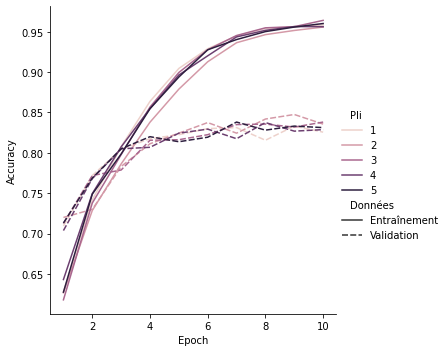

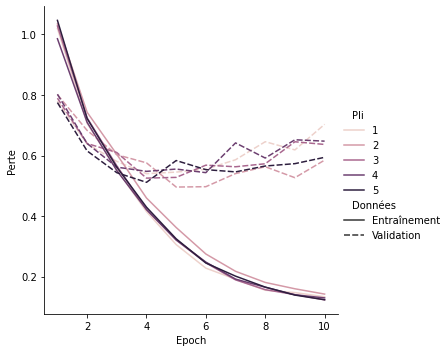

In [16]:
accuracy_data = []
loss_data = []
for i, h in enumerate(histories):
  acc = h.history['acc']
  val_acc = h.history['val_acc']
  loss = h.history['loss']
  val_loss = h.history['val_loss']
  for j in range(len(acc)):
    accuracy_data.append([i+1, j+1, acc[j], 'Entraînement'])
    accuracy_data.append([i+1, j+1, val_acc[j], 'Validation'])
    loss_data.append([i+1, j+1, loss[j], 'Entraînement'])
    loss_data.append([i+1, j+1, val_loss[j], 'Validation'])

acc_df = pd.DataFrame(accuracy_data, 
                      columns=['Pli', 'Epoch', 'Accuracy', 'Données'])
sns.relplot(data=acc_df, x='Epoch', y='Accuracy', hue='Pli', style='Données',
            kind='line')
  
loss_df = pd.DataFrame(loss_data, columns=['Pli', 'Epoch', 'Perte', 'Données'])
sns.relplot(data=loss_df, x='Epoch', y='Perte', hue='Pli', style='Données',
            kind='line')

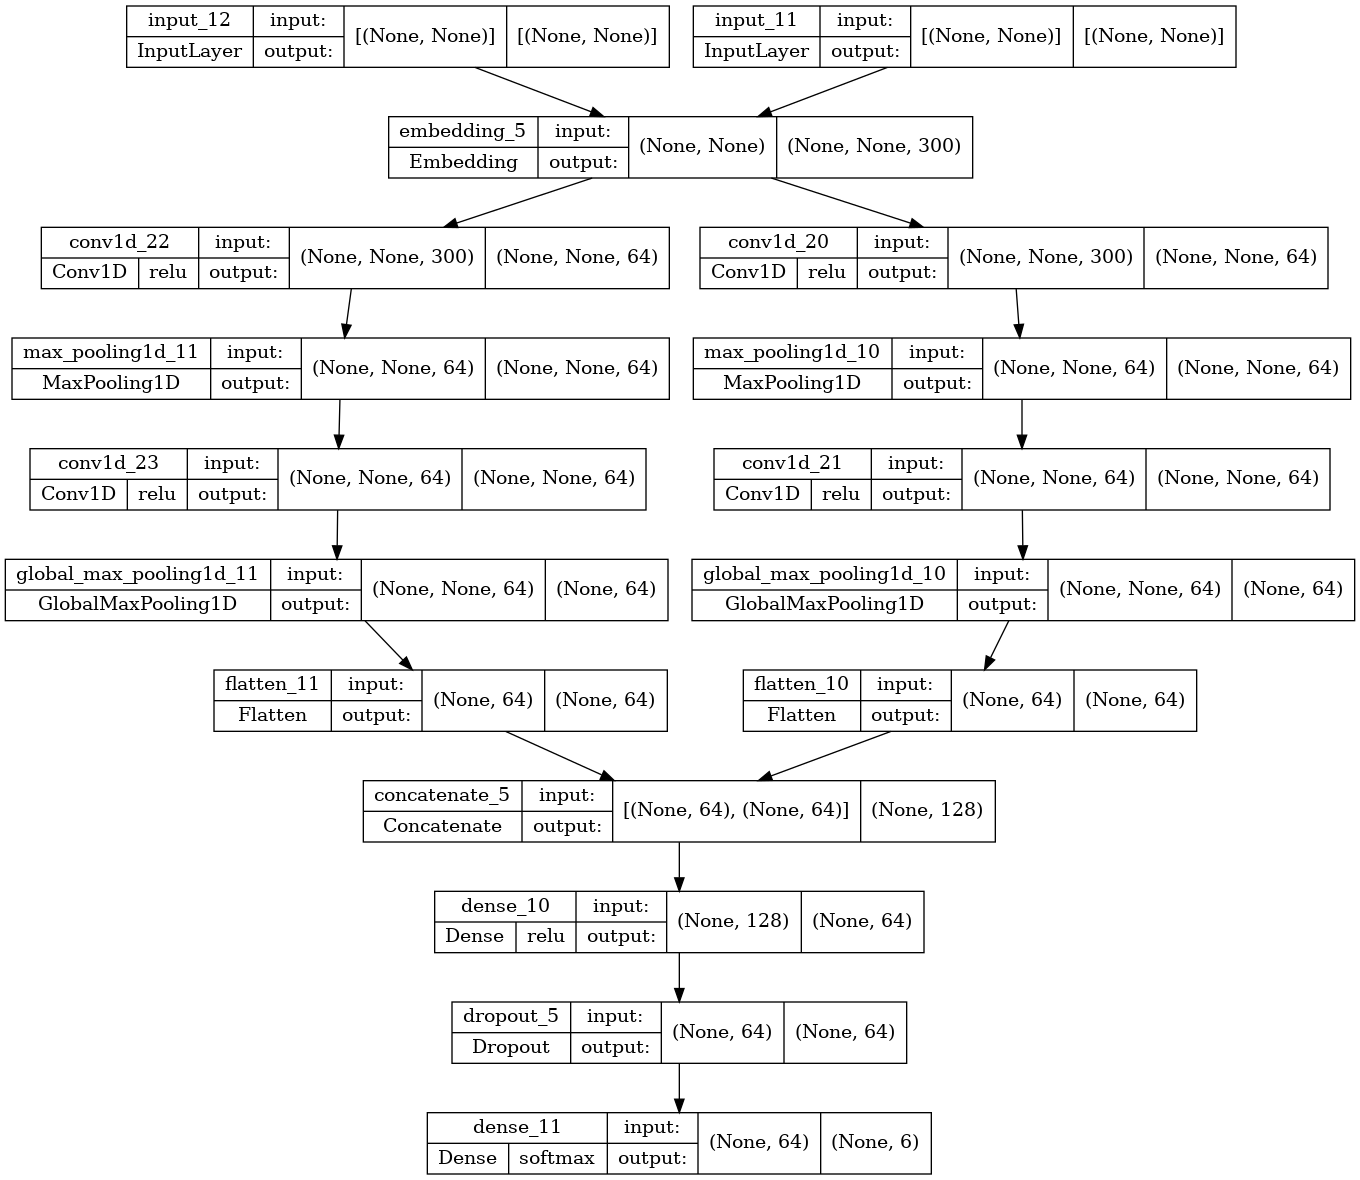

In [61]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, show_layer_activations=True)

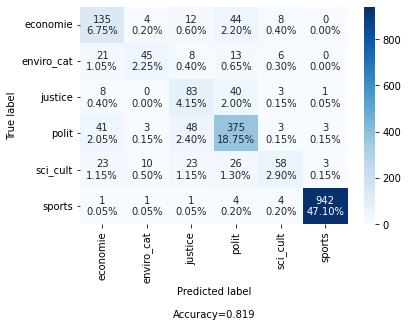

In [56]:
# Matrice de confusion
y_pred = np.argmax(model.predict([vectorizer(X_test['title']), vectorizer(X_test['text'])]), axis=1)
y_test_format = y_test.to_numpy()
labels = np.unique(y_test)
cm =  confusion_matrix(y_test, y_pred, labels=labels)
make_confusion_matrix(cm, categories = ['economie', 'enviro_cat', 'justice', 'polit', 'sci_cult', 'sports'])